In [1]:
import numpy as np
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, Activation
from keras.datasets import imdb
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap

# Load in hurricane data
atlantic = np.load("../Data/atlantic_series.pickle",allow_pickle=True)
pacific = np.load("../Data/pacific_series.pickle",allow_pickle=True)

In [103]:
def featurize(df, mode='short'):
    if mode == 'long':
        return df[['Latitude','Longitude','Max Wind', 'Min Pressure',
           'Wind Radii Max Extent 1', 'Wind Radii Max Extent 2',
           'Wind Radii Max Extent 3', 'Wind Radii Max Extent 4',
           'Wind Radii Max Extent 5', 'Wind Radii Max Extent 6',
           'Wind Radii Max Extent 7', 'Wind Radii Max Extent 8',
           'Wind Radii Max Extent 9', 'Wind Radii Max Extent 10',
           'Wind Radii Max Extent 11', 'Wind Radii Max Extent 12']].iloc[1:,:].values
    elif mode == 'medium':
#         print("Using 4 feautures")
        return df[['Latitude','Longitude','Max Wind', 'Min Pressure']].iloc[1:,:].values

    else:
        return df[['Latitude','Longitude']].iloc[1:,:].values
        
# Each time series event is a 16-long vector or a 4-long vector

def pad(hurricane_data, max_len):
    time_steps, dimension = hurricane_data.shape
    # Atlantic has max_len = 96
    return np.vstack((hurricane_data,np.zeros((max_len-time_steps,dimension))))

def get_features(data,long_or_short='short', pad=False):
    if pad:
        max_len = max([len(a) for a in data]) - 1
        hurricanes = [pad(featurize(df,long_or_short),max_len) for df in data]
    else:
        hurricanes = [featurize(df,long_or_short) for df in data]
    return hurricanes

aX = get_features(atlantic)

In [104]:
class HurricaneScales():
    def __init__(self,hurricane,long_or_short):
        self.pX = get_features(hurricane,long_or_short) # Could have been aX too
        self.width = self.pX[0].shape[1]
    
        self.maxs = [max([max(H[:,i]) for H in self.pX]) for i in range(self.width)]
        self.mins = [min([min(H[:,i]) for H in self.pX]) for i in range(self.width)]
        self.rescale()
        
        
    def rescale(self):
        self.scaled_pX = []
        for A in self.pX:
            B = A.copy()
            for i in range(self.width):
                B[:,i] = (B[:,i] - self.mins[i]) / self.maxs[i]
            self.scaled_pX.append(B)
         
            
    def unscale(self, pred, num_cols=None):
        # Assuming predictions are only latitude and longitude?
        if num_cols is None:
            num_cols = self.width
        
        unscaled_pred = []
        if len(pred.shape) == 3:
            d,r,c = pred.shape
            for j in range(d):
                B = pred[j,:,:]
                for i in range(num_cols):
                    B[:,i] = (self.maxs[i] * B[:,i]) + self.mins[i]
                unscaled_pred.append(B)
            return unscaled_pred
        else:
            for i in range(num_cols):
                pred[:,i] = (self.maxs[i] * pred[:,i]) + self.mins[i]
            return pred


In [105]:
def split_sequences(sequences, n_steps): # MachineLearningMastery.com
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
     

def load_data(hurricanes, n_steps=5, long_or_short='short'):
    features = HurricaneScales(hurricanes,long_or_short)
    data = features.scaled_pX
    X1, y1 = split_sequences(data[0], n_steps=n_steps)
    for i in range(1,len(data)):
        X2, y2 = split_sequences(data[i], n_steps=n_steps)
        if sum(X2.shape) != 0:
            X1 = np.vstack((X1,X2))
            y1 = np.vstack((y1,y2))
    return X1,y1

# This model will take in weather data at n time steps to predict the next weather pattern

def build_model(dimension,n_steps,num_lstms):
    model = Sequential()

    for x in range(num_lstms-1):
        model.add(LSTM(dimension,input_shape=(n_steps,dimension), return_sequences=True))
        model.add(Dropout(0.2))

    model.add(LSTM(dimension,input_shape=(1,n_steps,dimension), return_sequences=False)) 
    model.add(Dropout(0.2))

    model.add(Dense(dimension))
    model.add(Activation('relu'))

    start = time.time()
    model.compile(loss="mse", optimizer="adam",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


In [62]:
def load_data_train_model(ocean,n_steps,test_size,random_state,num_lstms,data_width,batch_size,epochs,long_or_short='short'):
    # Train on the atlantic data
    X,y = load_data(ocean,n_steps=n_steps,long_or_short=long_or_short)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = build_model(data_width,n_steps,num_lstms)
    model.fit(X_train, y_train, 
       batch_size = batch_size, 
       epochs = epochs, 
       validation_data = (X_test, y_test)
       )
    return model

In [132]:
def predict_trajectory(hurricanes, hurr_index, model, n_steps, amount_seen=.8, only_lat_long=True):
    if only_lat_long == False:
        long_or_short = 'medium'
    else:
        long_or_short = 'short'
    def predict_next(n_time_steps,model):
#         print(len(time_step))
        a,b = n_time_steps.shape
        next_ = model.predict(n_time_steps.reshape(1,a,b))[0]
#         print(next_)
        return next_
    scaler = HurricaneScales(hurricanes,long_or_short)
#     X,y = load_data(atlantic)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    H = scaler.scaled_pX[hurr_index]
    num_rows = H.shape[0]
    print(H.shape)
    print(num_rows)
    print(hurricanes[hurr_index].shape[0])
    start = int(amount_seen * num_rows)
    print(start)
#     print(start)
#     print(H)
    print()
    initial_path = H[:start,:]
    initial_path = scaler.unscale(initial_path, num_cols=2)
    n_time_steps = H[start-n_steps:start,:]
#     print(n_time_steps)
#     print(time_step)
    predictions = []
    true = []
    for i,j in enumerate(range(start,num_rows)):
        predictions.append(predict_next(n_time_steps,model))
        true.append(H[j,:])
        n_time_steps = np.vstack((n_time_steps[1:,:],predictions[i]))
        
    predictions = np.array([ p for p in predictions])
#     print(predictions)
    predictions = scaler.unscale(predictions, num_cols=None)
#     print(predictions)
    true = np.array(true)
    true = scaler.unscale(true, num_cols=true.shape[1])
    if only_lat_long:
        return predictions[:,:2],true[:,:2],initial_path[:,:2]
    else:
        return predictions,true,initial_path

# predict_trajectory(atlantic, 15, model,5,only_lat_long=False)
#

In [57]:
def plot_trajectory(hurricanes,i,model,n_steps,amount_seen=.8, is_atlantic=True):
    # Graph the trajectories of the longest hurricanes (the ones that traveled the most)
    plt.figure(figsize=(12,9))
    if is_atlantic:
        # Set up the map and the longitude-latitude window
        m = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=0.,urcrnrlat=60.,
                    rsphere=(6378137.00,6356752.3142),
                    resolution='h',
                    projection='merc',
                    lat_0=40.,lon_0=-20.,lat_ts=20.)

        # Plot the pretty NASA picture
        m.shadedrelief()
        m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
        m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
    else:
#         plt.figure(figsize=(12,9))
        m = Basemap(llcrnrlon=-181.,llcrnrlat=-10.,urcrnrlon=-81.,urcrnrlat=50.,
                    rsphere=(6378137.00,6356752.3142),
                    resolution='h',
                    projection='merc',
                    lat_0=40.,lon_0=-20.,lat_ts=20.)
        m.shadedrelief()
        # m.fillcontinents(color='#D3D3D3')
        m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
        m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

    colors = ['blue','red','green','yellow','orange','lime','pink','purple','cyan','brown']

    # Plot the trajectories

    # indices to try: [  8, 159, 227, 240, 247]
    year = hurricanes[i]['Date'].values[0][-4:]
    name = hurricanes[i]['Time'].values[0].strip()
    lat = hurricanes[i]["Latitude"][1:].values
    long = -hurricanes[i]["Longitude"][1:].values # Make sure the longitude has the sign change
    pred,true,init_path = predict_trajectory(hurricanes,i,model,n_steps=n_steps,amount_seen=amount_seen)
    pred_lat = pred[:,0].astype("float64")
    pred_long = -pred[:,1].astype("float64")
    true_lat = true[:,0].astype("float64")
    true_long = -true[:,1].astype("float64")
    xpt, ypt = m(long, lat)
    pred_xpt, pred_ypt = m(pred_long, pred_lat)
    txpt, typt = m(true_long, true_lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, f'{name} ({year})', color='black')
    plt.text(pred_xpt[len(pred_lat) - 1]+100000,pred_ypt[len(pred_long) - 1]+100000, 'PREDICTION', color='black')
    m.plot(xpt, ypt, linewidth=2, color='blue')
    m.plot(pred_xpt, pred_ypt, linewidth=4, color='red')
    m.plot(txpt,typt, linewidth=4, color='green')

    plt.title('Trajectory Prediction', fontsize=22)
    # plt.savefig('atlantic_hurricanes')
    plt.show()

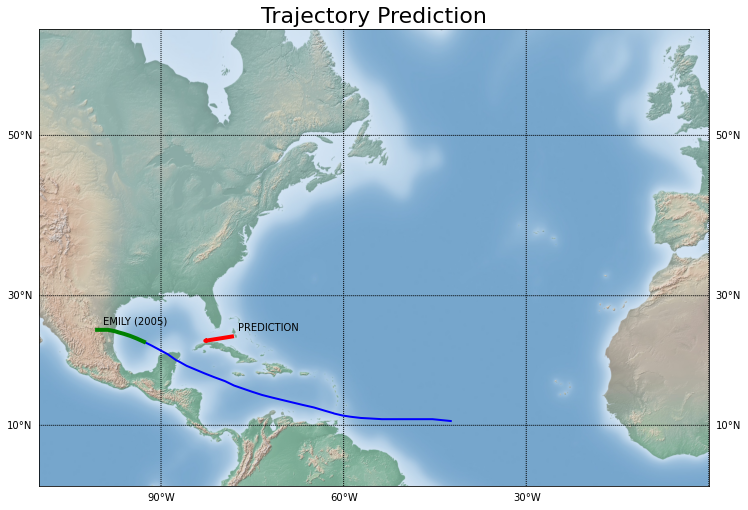

In [13]:
a_model2 = load_data_train_model(atlantic,n_steps=2,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(atlantic,20,a_model2,n_steps=2,amount_seen=.8)
am2_paths = predict_trajectory(atlantic, 20, a_model2, n_steps=2, amount_seen=.8, only_lat_long=True)


Compilation Time :  0.005523204803466797
Epoch 1/10
722/722 [==============================] - 17s 13ms/step - loss: 0.1265 - accuracy: 0.8190 - val_loss: 0.0262 - val_accuracy: 0.8448
Epoch 2/10
722/722 [==============================] - 7s 10ms/step - loss: 0.0271 - accuracy: 0.8255 - val_loss: 0.0150 - val_accuracy: 0.8933
Epoch 3/10
722/722 [==============================] - 7s 9ms/step - loss: 0.0197 - accuracy: 0.8807 - val_loss: 0.0134 - val_accuracy: 0.9432
Epoch 4/10
722/722 [==============================] - 7s 9ms/step - loss: 0.0173 - accuracy: 0.8784 - val_loss: 0.0126 - val_accuracy: 0.9473
Epoch 5/10
722/722 [==============================] - 7s 10ms/step - loss: 0.0166 - accuracy: 0.8865 - val_loss: 0.0120 - val_accuracy: 0.9550
Epoch 6/10
722/722 [==============================] - 8s 11ms/step - loss: 0.0161 - accuracy: 0.8848 - val_loss: 0.0122 - val_accuracy: 0.9466
Epoch 7/10
722/722 [==============================] - 8s 11ms/step - loss: 0.0157 - accuracy: 0.8887 -

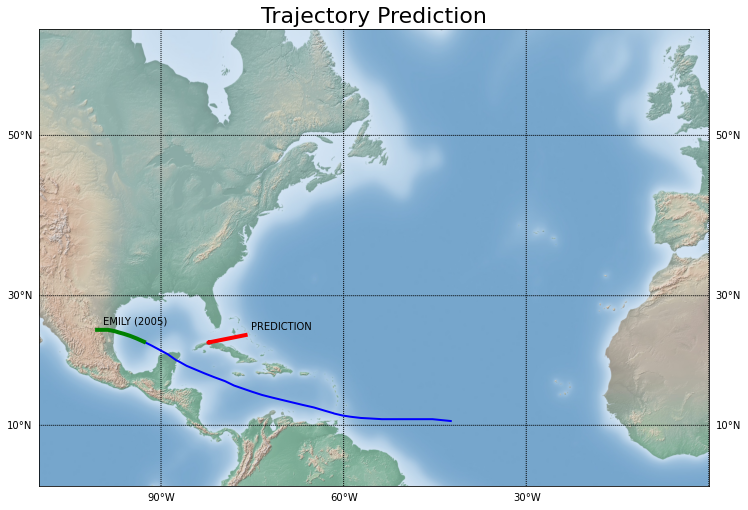

In [19]:
a_model3 = load_data_train_model(atlantic,n_steps=3,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(atlantic,20,a_model3,n_steps=3,amount_seen=.8)
am3_paths = predict_trajectory(atlantic, 20, a_model3, n_steps=3, amount_seen=.8, only_lat_long=True)

In [124]:
# a_model4 = load_data_train_model(atlantic,n_steps=4,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
# plot_trajectory(atlantic,20,a_model4,n_steps=4,amount_seen=.8)
am4_paths = predict_trajectory(atlantic, 20, a_model4, n_steps=4, amount_seen=.8, only_lat_long=True)

(44, 2)
44
35


Compilation Time :  0.0055599212646484375
Epoch 1/10
669/669 [==============================] - 16s 15ms/step - loss: 0.1088 - accuracy: 0.5074 - val_loss: 0.0236 - val_accuracy: 0.8407
Epoch 2/10
669/669 [==============================] - 10s 15ms/step - loss: 0.0306 - accuracy: 0.8359 - val_loss: 0.0142 - val_accuracy: 0.8407
Epoch 3/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0203 - accuracy: 0.8586 - val_loss: 0.0135 - val_accuracy: 0.8594
Epoch 4/10
669/669 [==============================] - 9s 13ms/step - loss: 0.0181 - accuracy: 0.8694 - val_loss: 0.0127 - val_accuracy: 0.9095
Epoch 5/10
669/669 [==============================] - 9s 13ms/step - loss: 0.0168 - accuracy: 0.8830 - val_loss: 0.0118 - val_accuracy: 0.9432
Epoch 6/10
669/669 [==============================] - 9s 14ms/step - loss: 0.0165 - accuracy: 0.8745 - val_loss: 0.0122 - val_accuracy: 0.9334
Epoch 7/10
669/669 [==============================] - 12s 18ms/step - loss: 0.0159 - accuracy: 0.

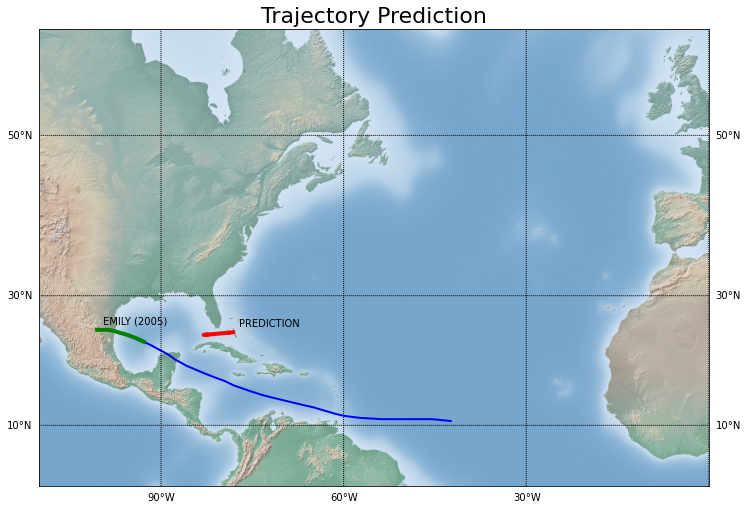

In [21]:
a_model5 = load_data_train_model(atlantic,n_steps=5,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(atlantic,20,a_model5,n_steps=5,amount_seen=.8)
am5_paths = predict_trajectory(atlantic, 20, a_model5, n_steps=5, amount_seen=.8, only_lat_long=True)

In [140]:
pm4 = load_data_train_model(pacific,n_steps=4,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
# plot_trajectory(pacific,28,pm4,n_steps=4,amount_seen=.8,is_atlantic=False)
# pm4_paths = predict_trajectory(pacific, 28, pm4, n_steps=4, amount_seen=.8, only_lat_long=True)




Compilation Time :  0.03190875053405762
Epoch 1/10
771/771 [==============================] - 27s 17ms/step - loss: 0.0282 - accuracy: 0.4738 - val_loss: 0.0052 - val_accuracy: 0.7463
Epoch 2/10
771/771 [==============================] - 12s 16ms/step - loss: 0.0064 - accuracy: 0.7498 - val_loss: 0.0039 - val_accuracy: 0.7936
Epoch 3/10
771/771 [==============================] - 9s 11ms/step - loss: 0.0056 - accuracy: 0.7670 - val_loss: 0.0039 - val_accuracy: 0.8099
Epoch 4/10
771/771 [==============================] - 9s 11ms/step - loss: 0.0052 - accuracy: 0.7802 - val_loss: 0.0037 - val_accuracy: 0.8092
Epoch 5/10
771/771 [==============================] - 8s 11ms/step - loss: 0.0052 - accuracy: 0.7662 - val_loss: 0.0036 - val_accuracy: 0.8228
Epoch 6/10
771/771 [==============================] - 10s 13ms/step - loss: 0.0051 - accuracy: 0.7799 - val_loss: 0.0037 - val_accuracy: 0.8209
Epoch 7/10
771/771 [==============================] - 9s 12ms/step - loss: 0.0048 - accuracy: 0.799

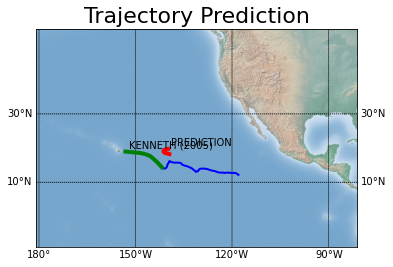

In [67]:
# pm44 = load_data_train_model(pacific,n_steps=4,test_size=.2,random_state=42,num_lstms=5,data_width=4,batch_size=8,epochs=20,long_or_short='medium')
# plot_trajectory(pacific,28,pm44,n_steps=4,amount_seen=.8,is_atlantic=False)
# pm44_paths = predict_trajectory(pacific, 28, pm44, n_steps=4, amount_seen=.8, only_lat_long=False)
# KENNETH
hurricanes = pacific
i = 28
m = Basemap(llcrnrlon=-181.,llcrnrlat=-10.,urcrnrlon=-81.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='h',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.shadedrelief()
# m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

colors = ['blue','red','green','yellow','orange','lime','pink','purple','cyan','brown']

# Plot the trajectories

# indices to try: [  8, 159, 227, 240, 247]
year = hurricanes[i]['Date'].values[0][-4:]
name = hurricanes[i]['Time'].values[0].strip()
lat = hurricanes[i]["Latitude"][1:].values
long = -hurricanes[i]["Longitude"][1:].values # Make sure the longitude has the sign change
pred,true,init_path = pm44_paths#predict_trajectory(hurricanes,i,model,n_steps=n_steps,amount_seen=amount_seen)
pred_lat = pred[:,0].astype("float64")
pred_long = -pred[:,1].astype("float64")
true_lat = true[:,0].astype("float64")
true_long = -true[:,1].astype("float64")
xpt, ypt = m(long, lat)
pred_xpt, pred_ypt = m(pred_long, pred_lat)
txpt, typt = m(true_long, true_lat)
plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, f'{name} ({year})', color='black')
plt.text(pred_xpt[len(pred_lat) - 1]+100000,pred_ypt[len(pred_long) - 1]+100000, 'PREDICTION', color='black')
m.plot(xpt, ypt, linewidth=2, color='blue')
m.plot(pred_xpt, pred_ypt, linewidth=4, color='red')
m.plot(txpt,typt, linewidth=4, color='green')

plt.title('Trajectory Prediction', fontsize=22)
# plt.savefig('atlantic_hurricanes')
plt.show()

Compilation Time :  0.005186796188354492
Epoch 1/10
739/739 [==============================] - 17s 14ms/step - loss: 0.0330 - accuracy: 0.5147 - val_loss: 0.0071 - val_accuracy: 0.6367
Epoch 2/10
739/739 [==============================] - 9s 12ms/step - loss: 0.0072 - accuracy: 0.7079 - val_loss: 0.0039 - val_accuracy: 0.7916
Epoch 3/10
739/739 [==============================] - 9s 12ms/step - loss: 0.0055 - accuracy: 0.7623 - val_loss: 0.0037 - val_accuracy: 0.8119
Epoch 4/10
739/739 [==============================] - 9s 12ms/step - loss: 0.0049 - accuracy: 0.7986 - val_loss: 0.0036 - val_accuracy: 0.8241
Epoch 5/10
739/739 [==============================] - 10s 13ms/step - loss: 0.0048 - accuracy: 0.8065 - val_loss: 0.0035 - val_accuracy: 0.8288
Epoch 6/10
739/739 [==============================] - 9s 13ms/step - loss: 0.0050 - accuracy: 0.8138 - val_loss: 0.0035 - val_accuracy: 0.8288
Epoch 7/10
739/739 [==============================] - 9s 12ms/step - loss: 0.0051 - accuracy: 0.812

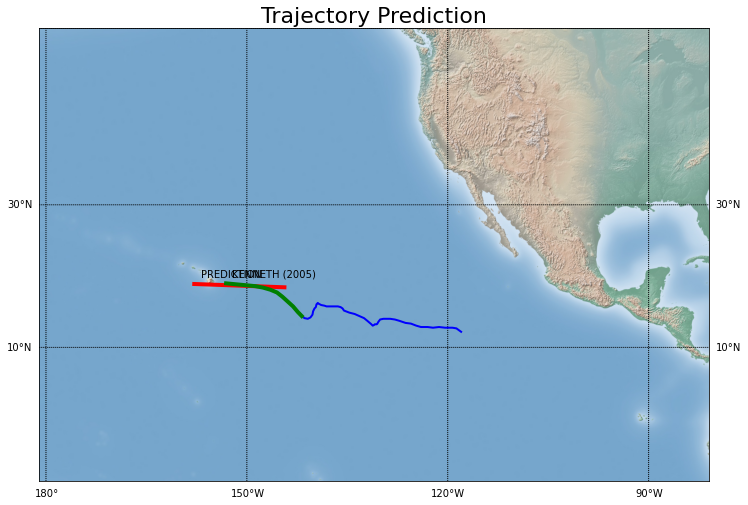

In [25]:
pm5 = load_data_train_model(pacific,n_steps=5,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(pacific,28,pm5,n_steps=5,amount_seen=.8,is_atlantic=False)
pm5_paths = predict_trajectory(pacific, 28, pm5, n_steps=5, amount_seen=.8, only_lat_long=True)

Compilation Time :  0.00533604621887207
Epoch 1/10
707/707 [==============================] - 14s 12ms/step - loss: 0.0408 - accuracy: 0.4717 - val_loss: 0.0039 - val_accuracy: 0.8587
Epoch 2/10
707/707 [==============================] - 8s 11ms/step - loss: 0.0058 - accuracy: 0.8393 - val_loss: 0.0037 - val_accuracy: 0.8643
Epoch 3/10
707/707 [==============================] - 8s 11ms/step - loss: 0.0052 - accuracy: 0.8421 - val_loss: 0.0036 - val_accuracy: 0.8473
Epoch 4/10
707/707 [==============================] - 7s 10ms/step - loss: 0.0051 - accuracy: 0.8326 - val_loss: 0.0036 - val_accuracy: 0.8424
Epoch 5/10
707/707 [==============================] - 6s 8ms/step - loss: 0.0049 - accuracy: 0.8357 - val_loss: 0.0036 - val_accuracy: 0.8382
Epoch 6/10
707/707 [==============================] - 6s 9ms/step - loss: 0.0050 - accuracy: 0.8280 - val_loss: 0.0037 - val_accuracy: 0.8339
Epoch 7/10
707/707 [==============================] - 9s 12ms/step - loss: 0.0049 - accuracy: 0.8335 - 

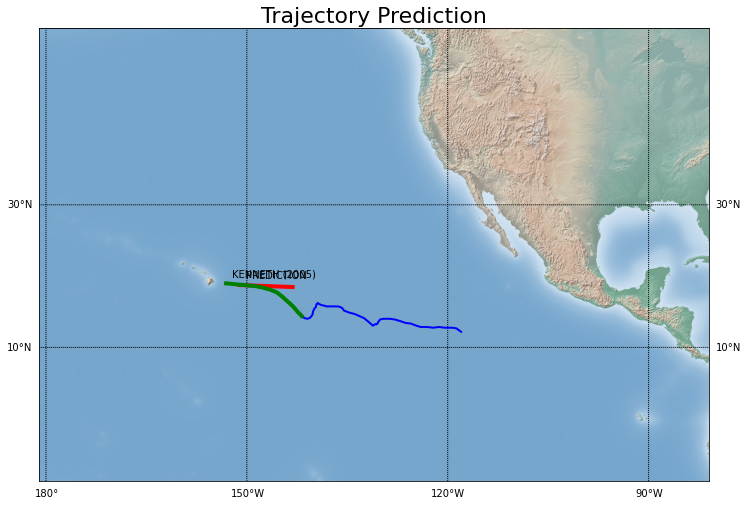

In [26]:
pm6 = load_data_train_model(pacific,n_steps=6,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(pacific,28,pm6,n_steps=6,amount_seen=.8,is_atlantic=False)
pm6_paths = predict_trajectory(pacific, 20, pm6, n_steps=6, amount_seen=.8, only_lat_long=True)

Compilation Time :  0.005115985870361328
Epoch 1/10
677/677 [==============================] - 20s 19ms/step - loss: 0.0453 - accuracy: 0.4908 - val_loss: 0.0049 - val_accuracy: 0.8071
Epoch 2/10
677/677 [==============================] - 11s 16ms/step - loss: 0.0062 - accuracy: 0.7572 - val_loss: 0.0039 - val_accuracy: 0.8293
Epoch 3/10
677/677 [==============================] - 11s 16ms/step - loss: 0.0056 - accuracy: 0.7657 - val_loss: 0.0037 - val_accuracy: 0.8344
Epoch 4/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0059 - accuracy: 0.7782 - val_loss: 0.0038 - val_accuracy: 0.8367
Epoch 5/10
677/677 [==============================] - 8s 12ms/step - loss: 0.0054 - accuracy: 0.7898 - val_loss: 0.0037 - val_accuracy: 0.8219
Epoch 6/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0051 - accuracy: 0.8035 - val_loss: 0.0037 - val_accuracy: 0.8285
Epoch 7/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0050 - accuracy: 0.79

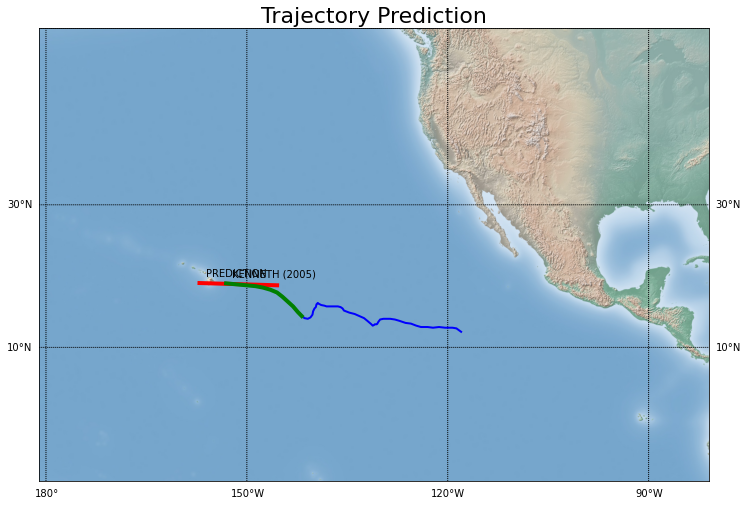

In [27]:
pm7 = load_data_train_model(pacific,n_steps=7,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=10)
plot_trajectory(pacific,28,pm7,n_steps=7,amount_seen=.8,is_atlantic=False)
pm7_paths = predict_trajectory(pacific, 20, pm7, n_steps=7, amount_seen=.8, only_lat_long=True)

In [ ]:
## We note the interesting observation that the more time-steps back we look, the more linear the prediction is.
## This could be due to the model somehow averaging out the perturbations in the path from point A to point B

# Extra Tests

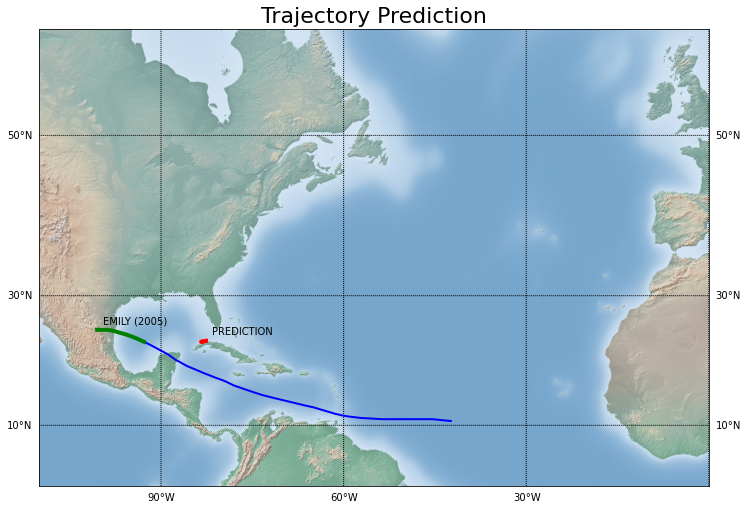

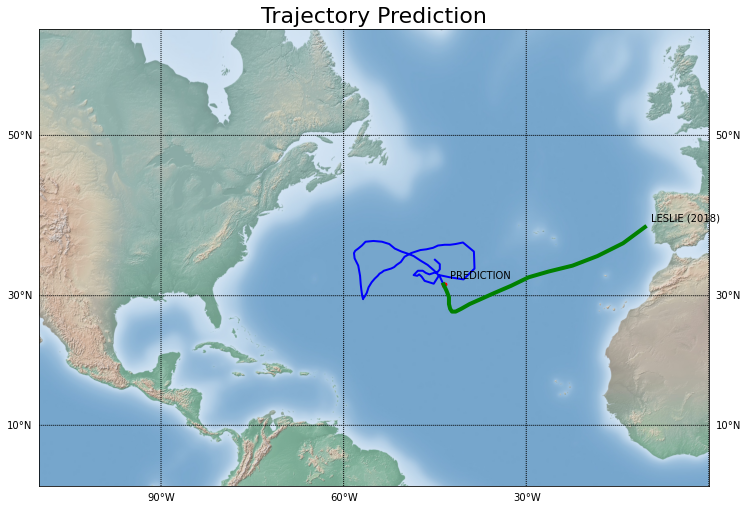

In [76]:
# a_model5_LL = load_data_train_model(atlantic,n_steps=5,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=20)
plot_trajectory(atlantic,20,a_model5_LL,n_steps=5,amount_seen=.8)
plot_trajectory(atlantic,247,a_model5_LL,n_steps=5,amount_seen=.8)
# plot_trajectory(atlantic,227,a_model5,n_steps=5,amount_seen=.8)
# plot_trajectory(atlantic,28,a_model5,n_steps=5,amount_seen=.8)

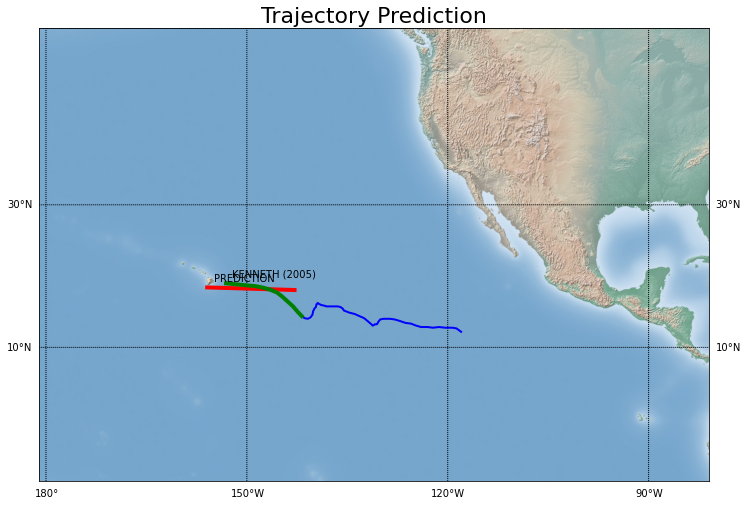

In [75]:
# p_model5_LL = load_data_train_model(pacific,n_steps=5,test_size=.2,random_state=42,num_lstms=5,data_width=2,batch_size=8,epochs=20)
plot_trajectory(pacific,28,p_model5_LL,n_steps=5,amount_seen=.8,is_atlantic=False)

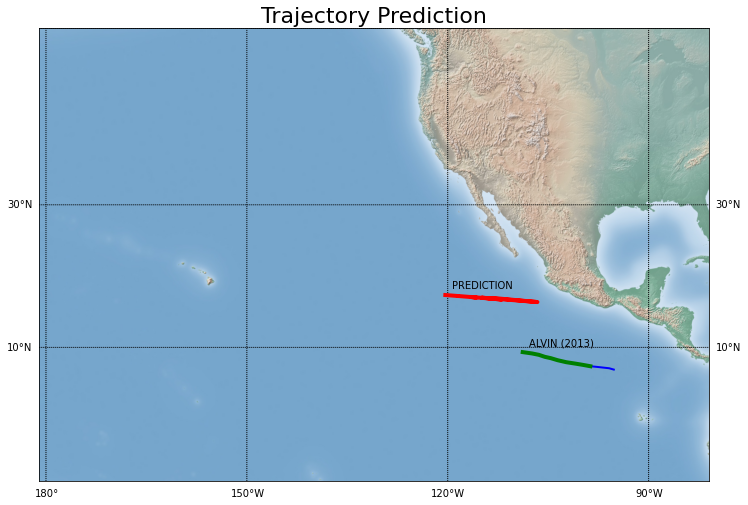

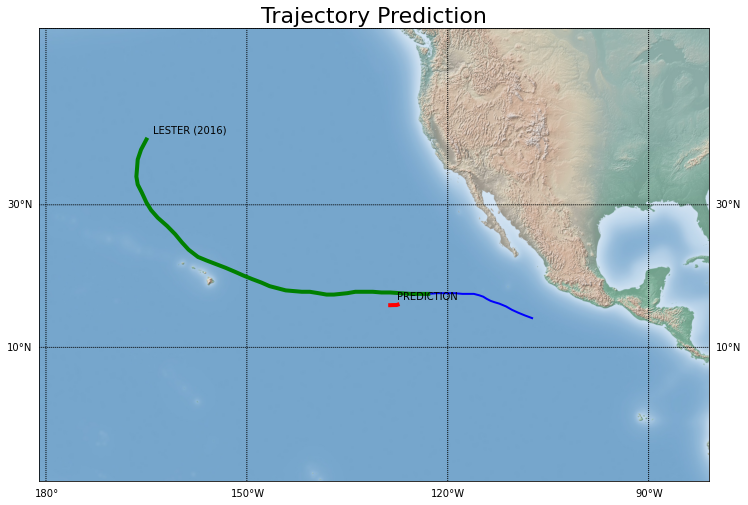

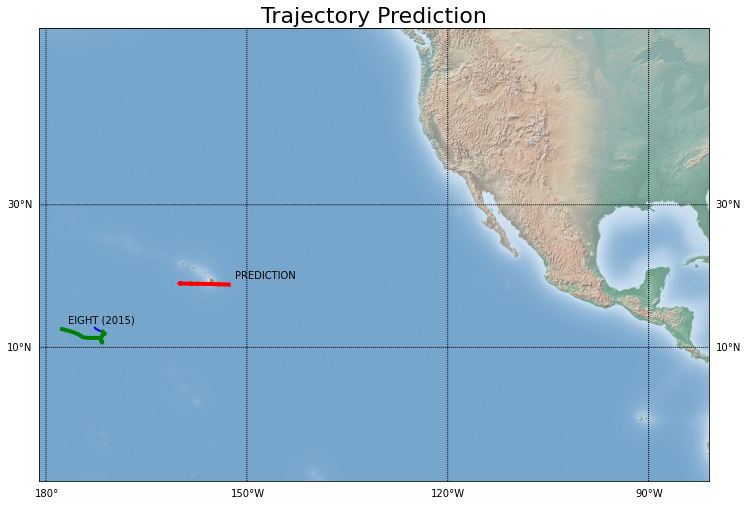

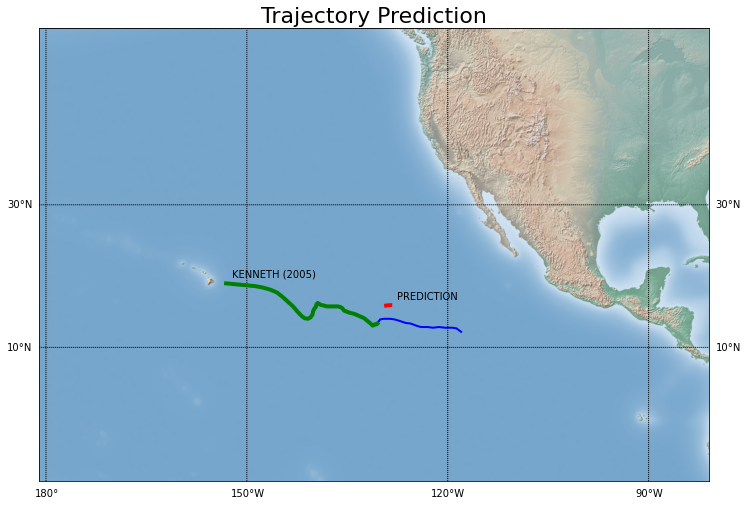

In [61]:
p_model2 = load_data_train_model(pacific,n_steps=2,test_size=.2,random_state=42,num_lstms=5,data_width=4,batch_size=4,epochs=20)
plot_trajectory(pacific,159,p_model2,n_steps=2,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,247,p_model2,n_steps=2,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,227,p_model2,n_steps=2,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,28,p_model2,n_steps=2,amount_seen=.8,is_atlantic=False)

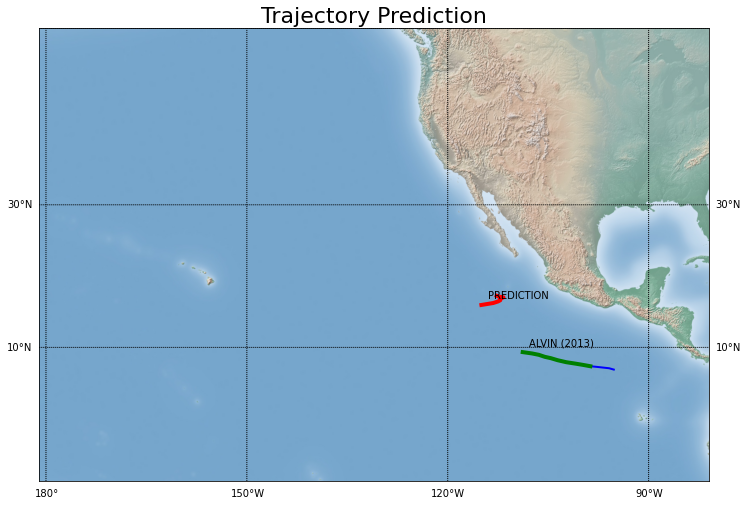

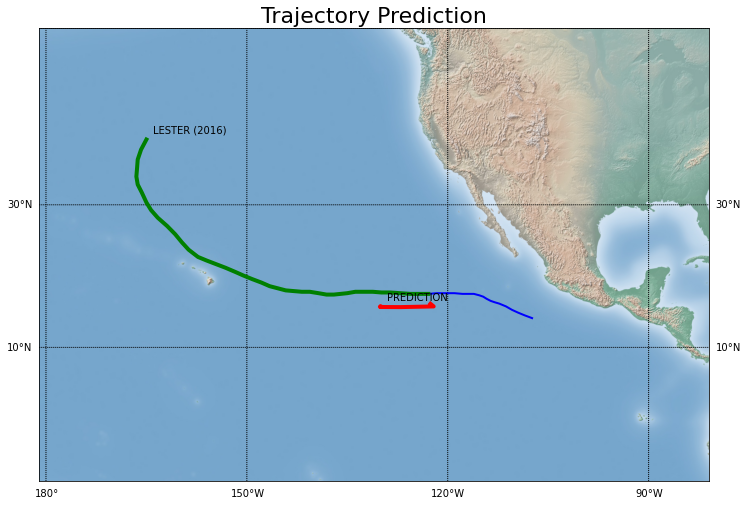

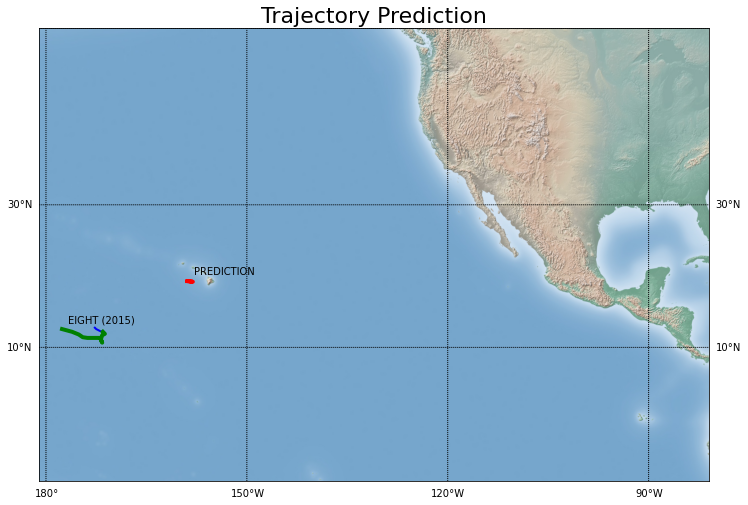

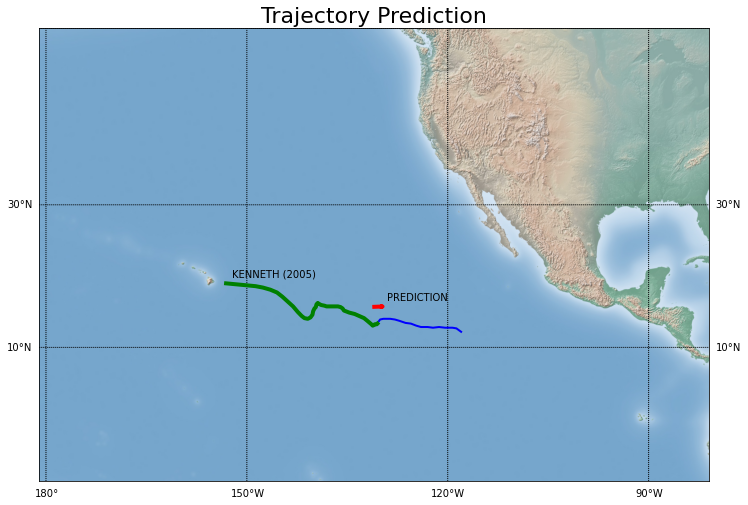

In [63]:
# p_model3 = load_data_train_model(pacific,n_steps=3,test_size=.2,random_state=42,num_lstms=5,data_width=4,batch_size=4,epochs=20)
plot_trajectory(pacific,159,p_model3,n_steps=3,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,247,p_model3,n_steps=3,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,227,p_model3,n_steps=3,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,28,p_model3,n_steps=3,amount_seen=.8,is_atlantic=False)

Compilation Time :  0.05926990509033203
Epoch 1/20
1541/1541 [==============================] - 114s 44ms/step - loss: 0.0164 - accuracy: 0.5041 - val_loss: 0.0084 - val_accuracy: 0.5282
Epoch 2/20
1541/1541 [==============================] - 78s 51ms/step - loss: 0.0089 - accuracy: 0.5301 - val_loss: 0.0072 - val_accuracy: 0.5782
Epoch 3/20
1541/1541 [==============================] - 108s 70ms/step - loss: 0.0085 - accuracy: 0.5371 - val_loss: 0.0068 - val_accuracy: 0.6087
Epoch 4/20
1541/1541 [==============================] - 41s 27ms/step - loss: 0.0078 - accuracy: 0.5809 - val_loss: 0.0058 - val_accuracy: 0.6275
Epoch 5/20
1541/1541 [==============================] - 40s 26ms/step - loss: 0.0070 - accuracy: 0.6182 - val_loss: 0.0052 - val_accuracy: 0.6619
Epoch 6/20
1541/1541 [==============================] - 39s 25ms/step - loss: 0.0064 - accuracy: 0.6358 - val_loss: 0.0047 - val_accuracy: 0.6872
Epoch 7/20
1541/1541 [==============================] - 35s 23ms/step - loss: 0.00

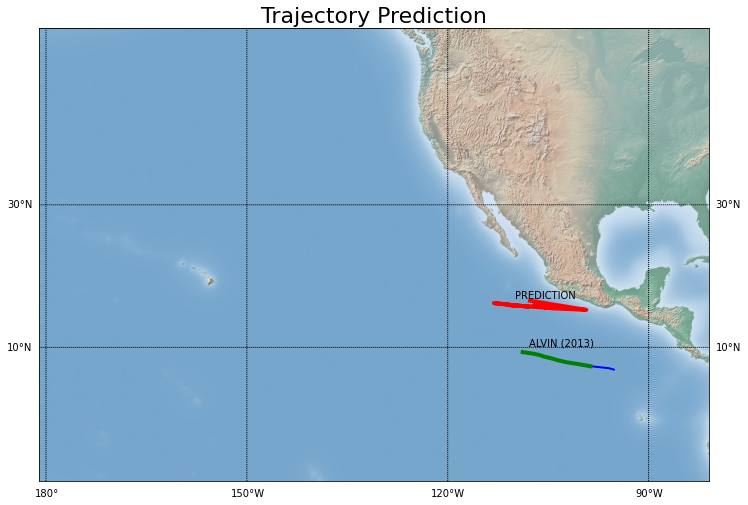

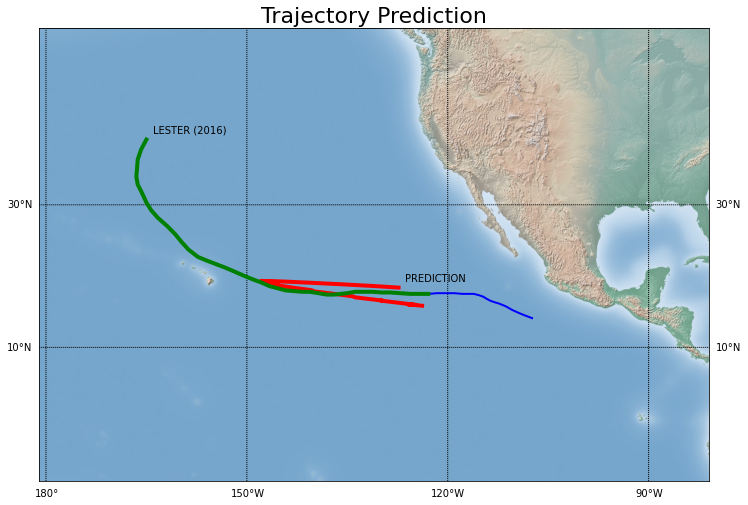

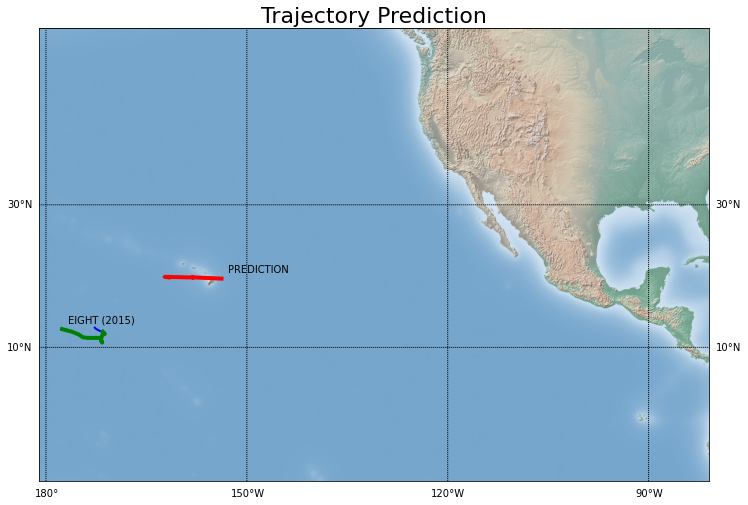

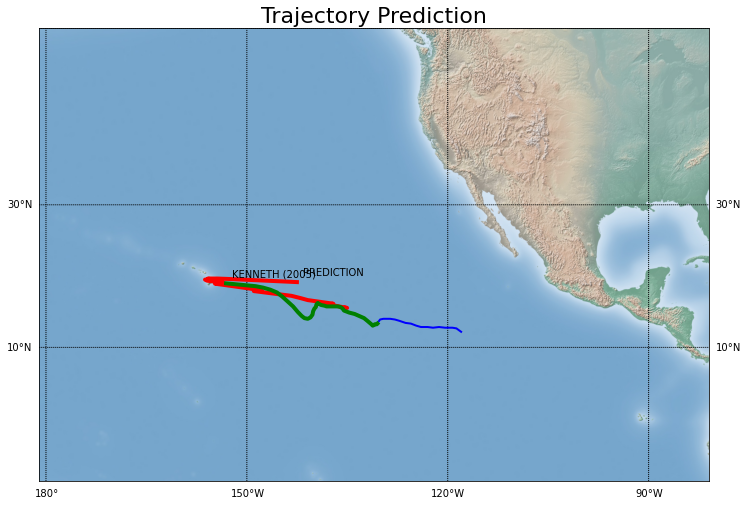

In [64]:
p_model4 = load_data_train_model(pacific,n_steps=4,test_size=.2,random_state=42,num_lstms=5,data_width=4,batch_size=4,epochs=20)
plot_trajectory(pacific,159,p_model4,n_steps=4,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,247,p_model4,n_steps=4,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,227,p_model4,n_steps=4,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,28,p_model4,n_steps=4,amount_seen=.8,is_atlantic=False)

Compilation Time :  0.018616199493408203
Epoch 1/20
1478/1478 [==============================] - 85s 34ms/step - loss: 0.0207 - accuracy: 0.4344 - val_loss: 0.0084 - val_accuracy: 0.3532
Epoch 2/20
1478/1478 [==============================] - 37s 25ms/step - loss: 0.0090 - accuracy: 0.5027 - val_loss: 0.0071 - val_accuracy: 0.5873
Epoch 3/20
1478/1478 [==============================] - 31s 21ms/step - loss: 0.0082 - accuracy: 0.5618 - val_loss: 0.0061 - val_accuracy: 0.6177
Epoch 4/20
1478/1478 [==============================] - 41s 28ms/step - loss: 0.0070 - accuracy: 0.6081 - val_loss: 0.0051 - val_accuracy: 0.6671
Epoch 5/20
1478/1478 [==============================] - 41s 28ms/step - loss: 0.0064 - accuracy: 0.6476 - val_loss: 0.0050 - val_accuracy: 0.6658
Epoch 6/20
1478/1478 [==============================] - 33s 22ms/step - loss: 0.0061 - accuracy: 0.6516 - val_loss: 0.0050 - val_accuracy: 0.6698
Epoch 7/20
1478/1478 [==============================] - 34s 23ms/step - loss: 0.006

ValueError: in user code:

    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1270 call
        runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1655 lstm_with_backend_selection
        last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(**params)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:2941 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:3361 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:3196 _create_graph_function
        func_graph_module.func_graph_from_py_func(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:990 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1392 standard_lstm
        last_output, outputs, new_states = K.rnn(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4345 rnn
        [inp[0] for inp in flatted_inputs])
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4345 <listcomp>
        [inp[0] for inp in flatted_inputs])
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:1036 _slice_helper
        return strided_slice(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:1209 strided_slice
        op = gen_array_ops.strided_slice(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:10474 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/thomasfackrell/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 0 of dimension 0 out of bounds. for '{{node strided_slice_1}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](transpose, strided_slice_1/stack, strided_slice_1/stack_1, strided_slice_1/stack_2)' with input shapes: [0,?,4], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.


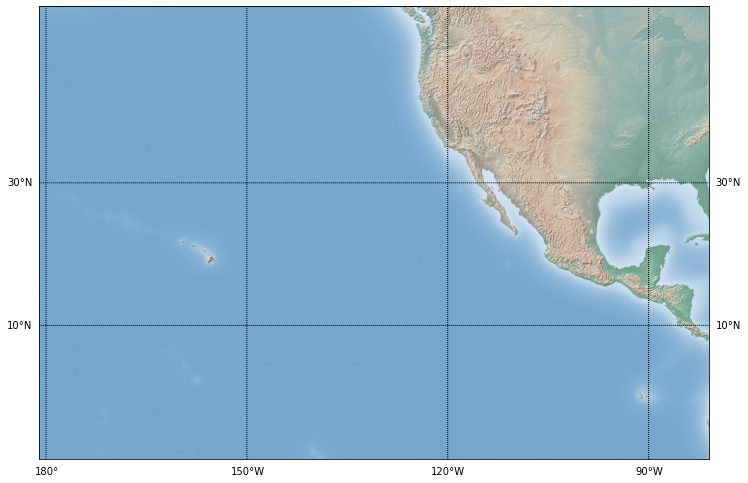

In [65]:
p_model5 = load_data_train_model(pacific,n_steps=5,test_size=.2,random_state=42,num_lstms=5,data_width=4,batch_size=4,epochs=20)
plot_trajectory(pacific,159,p_model5,n_steps=5,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,247,p_model5,n_steps=5,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,227,p_model5,n_steps=5,amount_seen=.8,is_atlantic=False)
plot_trajectory(pacific,28,p_model5,n_steps=5,amount_seen=.8,is_atlantic=False)

In [28]:
# Atlantic Emily 20
# Pacific Kenneth 28
am4_paths

(array([[24.188692, 84.44872 ],
        [24.155315, 84.74676 ],
        [24.166151, 84.655   ],
        [24.26793 , 83.75898 ],
        [24.529505, 81.48269 ],
        [24.534252, 81.44281 ],
        [24.578947, 81.064095],
        [24.66665 , 80.32465 ],
        [24.768232, 79.47543 ]], dtype=float32),
 array([[ 23.2,  92.8],
        [ 23.7,  94. ],
        [ 24.1,  95.1],
        [ 24.4,  96.1],
        [ 24.6,  96.9],
        [ 24.8,  97.6],
        [ 25. ,  98.7],
        [ 25. ,  99.7],
        [ 25. , 100.5]]),
 array([[0.04705882, 0.38800375],
        [0.04852941, 0.39737582],
        [0.05      , 0.40674789],
        [0.05147059, 0.41611996],
        [0.05147059, 0.42924086],
        [0.05147059, 0.44517338],
        [0.05147059, 0.4611059 ],
        [0.05147059, 0.47797563],
        [0.05147059, 0.49390815],
        [0.05294118, 0.50984067],
        [0.05441176, 0.5267104 ],
        [0.05735294, 0.54264292],
        [0.06029412, 0.55482662],
        [0.06470588, 0.56701031],
 

In [69]:
pm4_paths

(array([[24.188692, 84.44872 ],
        [24.155315, 84.74676 ],
        [24.166151, 84.655   ],
        [24.26793 , 83.75898 ],
        [24.529505, 81.48269 ],
        [24.534252, 81.44281 ],
        [24.578947, 81.064095],
        [24.66665 , 80.32465 ],
        [24.768232, 79.47543 ]], dtype=float32),
 array([[ 23.2,  92.8],
        [ 23.7,  94. ],
        [ 24.1,  95.1],
        [ 24.4,  96.1],
        [ 24.6,  96.9],
        [ 24.8,  97.6],
        [ 25. ,  98.7],
        [ 25. ,  99.7],
        [ 25. , 100.5]]),
 array([[0.04705882, 0.38800375],
        [0.04852941, 0.39737582],
        [0.05      , 0.40674789],
        [0.05147059, 0.41611996],
        [0.05147059, 0.42924086],
        [0.05147059, 0.44517338],
        [0.05147059, 0.4611059 ],
        [0.05147059, 0.47797563],
        [0.05147059, 0.49390815],
        [0.05294118, 0.50984067],
        [0.05441176, 0.5267104 ],
        [0.05735294, 0.54264292],
        [0.06029412, 0.55482662],
        [0.06470588, 0.56701031],
 

In [135]:
# Save the results of the hurricanes we want

import pickle
hurr_name = ["EMILY","KENNETH"]

ap,at,ai = am4_paths
pp,pt,pi = pm4_paths

y = [ai,pi]
y_test = [at,pt]
pred = [ap,pp]
# predictions,true,initial_path
for i in range(2):
    stuff_dict = {}
    stuff_dict['Hurricane Name'] = hurr_name[i]
    stuff_dict['Observed Points'] = y[i]
    stuff_dict['Used Parameters other than Long and Lat'] = False
    stuff_dict['True Trajectory'] = y_test[i]
    stuff_dict['Predicted Trajectory'] = pred[i]
    stuff_dict['Model Parameters (num_timesteps)'] = 4
    pickle.dump(stuff_dict, open(f'./../Data/RNN_{hurr_name[i]}.pickle', 'wb'))

In [136]:
k = pickle.load(open('./../Data/RNN_KENNETH.pickle','rb'))
e = pickle.load(open('./../Data/RNN_EMILY.pickle','rb'))

In [137]:
k

{'Hurricane Name': 'KENNETH',
 'Observed Points': array([[ 12.3, 118. ],
        [ 12.8, 118.7],
        [ 12.9, 119.3],
        [ 12.9, 119.8],
        [ 12.9, 120.4],
        [ 13. , 121.3],
        [ 12.9, 122.2],
        [ 13. , 123. ],
        [ 13. , 124. ],
        [ 13.2, 124.7],
        [ 13.5, 125.5],
        [ 13.6, 126.3],
        [ 13.9, 127.2],
        [ 14.1, 127.9],
        [ 14.2, 128.6],
        [ 14.2, 129.2],
        [ 14.2, 129.6],
        [ 14.1, 130.1],
        [ 13.7, 130.4],
        [ 13.5, 130.5],
        [ 13.4, 130.6],
        [ 13.4, 130.8],
        [ 13.4, 130.9],
        [ 13.3, 131. ],
        [ 13.2, 131.2],
        [ 13.4, 131.4],
        [ 13.9, 132. ],
        [ 14.3, 132.5],
        [ 14.6, 133.2],
        [ 14.9, 133.9],
        [ 15.1, 134.7],
        [ 15.4, 135.5],
        [ 15.7, 135.7],
        [ 15.9, 136. ],
        [ 16. , 136.4],
        [ 16. , 136.8],
        [ 16. , 137.2],
        [ 16. , 137.7],
        [ 16. , 138.1],
        [ 16.1,

In [142]:
pm4_paths_2 = predict_trajectory(pacific, 31, pm4, n_steps=4, amount_seen=.8, only_lat_long=True)
am4_paths_2 = predict_trajectory(atlantic, 99, a_model4, n_steps=4, amount_seen=.8, only_lat_long=True)

# p 31 norma
# a 99 fred

hurr_name = ["FRED","NORMA"]

ap,at,ai = am4_paths_2
pp,pt,pi = pm4_paths_2

y = [ai,pi]
y_test = [at,pt]
pred = [ap,pp]
# predictions,true,initial_path
for i in range(2):
    stuff_dict = {}
    stuff_dict['Hurricane Name'] = hurr_name[i]
    stuff_dict['Observed Points'] = y[i]
    stuff_dict['Used Parameters other than Long and Lat'] = False
    stuff_dict['True Trajectory'] = y_test[i]
    stuff_dict['Predicted Trajectory'] = pred[i]
    stuff_dict['Model Parameters (num_timesteps)'] = 4
    pickle.dump(stuff_dict, open(f'./../Data/RNN_{hurr_name[i]}.pickle', 'wb'))

(32, 2)
32
33
25

(47, 2)
47
48
37

